In [28]:
import pickle
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline 

import pandas as pd
import numpy as np


In [10]:
tweet_tokenizer = TweetTokenizer(preserve_case=True, strip_handles=True, reduce_len=True)
lemmatizer = WordNetLemmatizer()

def tokenize_lemmatize_tweet(tweet):
    ''' 
    Tokenize then Lemmatize the given tweet 
    '''
    #remove links
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    #tokenize
    tokens = tweet_tokenizer.tokenize(tweet)
    #lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

def calc_and_display_performance_metric(classifer, Xtest, ytest, Xtrain, ytrain, classifier_predictions, class_label_names):
    '''
    Calcuate and display peformance metrics for a classifier
    '''
    # Metrics - on how well the classifer performed on test data AND getting metrics on training data to check for model overfitting.
    train_predictions = classifer.predict(Xtrain)
    show_peformance_metrics(ytrain, train_predictions, Xtest, ytest, classifier_predictions, class_label_names)
    # Confusion Matrix
    plot_pretty_cf(classifer, Xtest, ytest)

def show_peformance_metrics(y_train, y_train_pred, X_test, y_test, y_pred, names):
    ''' 
    Print out peformance metrics
    '''
    train_acc_core = accuracy_score(y_train, y_train_pred)
    test_acc_score = accuracy_score(y_test, y_pred)
    train_wf1_score = f1_score(y_train, y_train_pred, average='weighted')
    test_wf1_score = f1_score(y_test, y_pred, average='weighted')
    print('--------------------------------------------------------------------------')
    print('Training Accuracy:{:.4}\t\t Testing Accuracy: {:.4}'.format(train_acc_core, test_acc_score))
    print('Training Weighted F1:{:.4}\t\t Testing Weighted F1: {:.4}'.format(train_wf1_score, test_wf1_score))
    print('--------------------------------------------------------------------------')
    print(classification_report(y_test, y_pred, target_names=names))
    print('--------------------------------------------------------------------------')

def plot_pretty_cf(predictor, Xtest, ytest, cmap='Blues', normalize='true', title=None):
    ''' Plot a pretty confusion matrix '''
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_confusion_matrix(predictor, Xtest, ytest, cmap=cmap, normalize=normalize, ax=ax)
    ax.set_title(title, size='large')
    ax.set_xlabel('Predicted Label', size='medium')
    ax.set_ylabel('True Label', size='medium')
    plt.show()

In [11]:
all_tweets_df = pd.read_csv('../data/all_tweets_combined.csv')
all_tweets_df.info()
all_tweets_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38392 entries, 0 to 38391
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        38392 non-null  int64 
 1   content           38392 non-null  object
 2   user_loc          38392 non-null  object
 3   user_screen_name  38392 non-null  object
 4   retweet_count     38392 non-null  int64 
 5   fav_count         38392 non-null  int64 
 6   created_at        38392 non-null  object
 7   char_count        38392 non-null  int64 
 8   sentiment_method  38392 non-null  object
 9   sentiment         38392 non-null  object
dtypes: int64(4), object(6)
memory usage: 2.9+ MB


(38392, 10)

In [12]:
tweets_content_sentiment_df = all_tweets_df[['content', 'sentiment']]
tweets_content_sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38392 entries, 0 to 38391
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    38392 non-null  object
 1   sentiment  38392 non-null  object
dtypes: object(2)
memory usage: 600.0+ KB


In [13]:
tweets_content_sentiment_df['sentiment'].value_counts()
# We have class imbalance here with MANY more positive tweets

positive    28259
neutral      6064
negative     4069
Name: sentiment, dtype: int64

* Create TRAIN and TEST data 

* Create the TFIDF Vectorizer to be used to tokenize and vectorize the data

* Create a Pipeline to use GridSearchCV to find best hyperparameters for model, and fit the best model
    * Use prepared TFID Vectorizer
    * Use "vanilla' classification model
    * Define parameter grid for consideration by GridSearchCV
    * Use GridSearchCV to peform hyperparameter tuning to fit/train the best model

* Create predictions for TEST set

* Examine performance metrics
    * Compare the performance metricx for TRAIN and TEST - If model does __much__ better on TRAIN than on TEST set, then we’re likely overfitting.

In [14]:
# Get TRAIN and TEST data and target and prep for processing steps
label_names = ['Negative', 'Neutral', 'Positive']
X = tweets_content_sentiment_df['content']
y = tweets_content_sentiment_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [15]:
# Text Processing - Vectorize the Tweets using - TF-IDF
# Use TF_IDF to focus on words that appear heavily in tweets from a given class, but rarely appear in tweets from other class/classes.
# Use custom function as tokenzier - uses TweetTokenier and NLTK Wordnet Lemmatizier on the resulting tokens
# Use english stopwords. Not removing/stripping punctuation as it may be useful for sentiment classifification

vectorizer = TfidfVectorizer(tokenizer=tokenize_lemmatize_tweet,
                             stop_words=stopwords.words('english'),
                             decode_error='ignore')

--------------------------------------------------------------------------
Training Accuracy:0.995		 Testing Accuracy: 0.9281
Training Weighted F1:0.995		 Testing Weighted F1: 0.9276
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.85      0.79      0.82      1251
     Neutral       0.85      0.86      0.86      1821
    Positive       0.96      0.96      0.96      8446

    accuracy                           0.93     11518
   macro avg       0.89      0.87      0.88     11518
weighted avg       0.93      0.93      0.93     11518

--------------------------------------------------------------------------


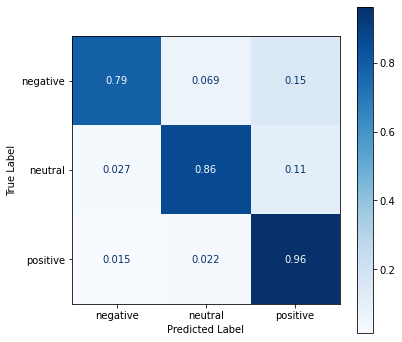

In [16]:
# Linear SVC with no hyperparameter tuning
not_tuned_lsvc_clf = Pipeline([('tfidf', vectorizer),
                               ('clf', LinearSVC(class_weight='balanced', max_iter=2000))
                               ])

not_tuned_lsvc_clf.fit(X_train, y_train)
predictions = not_tuned_lsvc_clf.predict(X_test)

calc_and_display_performance_metric(classifer=not_tuned_lsvc_clf, 
                                    Xtest=X_test, 
                                    ytest=y_test,
                                    Xtrain=X_train,
                                    ytrain=y_train,
                                    classifier_predictions=predictions,
                                    class_label_names=label_names)

In [17]:
# Linear SVC was very promising!  Let's perform hyperparameter tuning with GridSearchCV!

vanilla_lsvc_pipeline = Pipeline([ ('tfidf', vectorizer), ('estimator', LinearSVC()) ])

p_grid = {'estimator__penalty': ['l1', 'l2'],
          'estimator__class_weight': ['balanced'],
          'estimator__random_state': [42],
          'estimator__loss': ['hinge', 'squared_hinge'],
          'estimator__dual': [True, False],
          'estimator__C' : [.1, 1, 10],
          'estimator__max_iter' : [1000, 2000]
          }

#using 10 fold cross validation instead of default of 5
grid_lsvc = GridSearchCV(estimator=vanilla_lsvc_pipeline,
                          param_grid=p_grid,
                          scoring='f1_weighted',
                          verbose=1,
                          n_jobs=-1,
                          cv=10)

grid_lsvc.fit(X_train, y_train)
best_lsvc_clf = grid_lsvc.best_estimator_
print(grid_lsvc.best_score_)
print(grid_lsvc.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 32.9min finished
0.9413989659318884
{'estimator__C': 1, 'estimator__class_weight': 'balanced', 'estimator__dual': False, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 1000, 'estimator__penalty': 'l1', 'estimator__random_state': 42}


--------------------------------------------------------------------------
Training Accuracy:0.9824		 Testing Accuracy: 0.943
Training Weighted F1:0.9826		 Testing Weighted F1: 0.9432
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.85      0.81      0.83      1251
     Neutral       0.86      0.95      0.90      1821
    Positive       0.98      0.96      0.97      8446

    accuracy                           0.94     11518
   macro avg       0.90      0.91      0.90     11518
weighted avg       0.94      0.94      0.94     11518

--------------------------------------------------------------------------


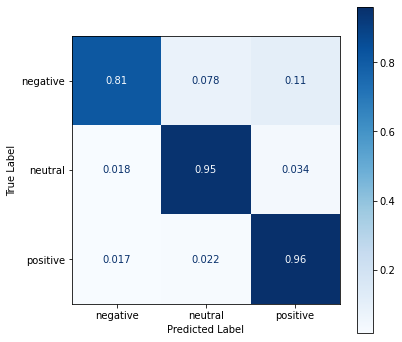

In [18]:
predictions = best_lsvc_clf.predict(X_test)

calc_and_display_performance_metric(classifer=best_lsvc_clf, 
                                    Xtest=X_test, 
                                    ytest=y_test,
                                    Xtrain=X_train,
                                    ytrain=y_train,
                                    classifier_predictions=predictions,
                                    class_label_names=label_names)

In [21]:
# Now that we've used Grid Search CV to determine the best hyperparameters for the LinearSVC model and have trained it. Pickle the trained model for use with new data.
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime('%d_%b_%Y_%H_%M')
timestamped_model_filename = 'fitted_lsvc_model_' + timestampStr + '.pickle'

with open(timestamped_model_filename, 'wb') as modelFile:
    pickle.dump(best_lsvc_clf, modelFile)

In [22]:
#Load pre-trained model - no need to retrain it again
with open(timestamped_model_filename, 'rb') as modelFile:
    stored_model = pickle.load(modelFile)


In [27]:
#Predict with new data
new_data = {'content': 
    ['@jac___13 Sorry Jackie! I’ve kept our kids fully remote, even opting out of the hybrid model. I just can’t trust other outside of my bubble right now. At least you guys in K-12 are in the earlier phases to get vaccinated. My wife in higher-Ed is not. I truly feel for educators right now.', 
    'Parents, Grandparents, and Guardians! Explore Pre-K and K-12 options, tour schools and chat LIVE with school representatives during our Virtual School Fair.\nhttps://t.co/ogqDR4m52K', 
    'Screw the open schools COVID movement for damaging the term open schools.\n\nAn Open School is a K-12 self-directed democratic school.\nJCOS in Denver Colorado is the last Open School in USA\n\nHere\'s an EP we released w/ a former student &amp; teacher.\n\nhttps://t.co/3hJ2sGwMLD https://t.co/jbIfpO80UP', 
    'How does creating a federally supported K-12 to postsecondary education pathway help America recover from the COVID-19 pandemic? \n\nRead the new @amprog report to learn more: https://t.co/mCTe84WFtO #CAPEducation', 
    'Parents! 🗣️ @DaytonLive365 is offering a free “virtual field trip” for local K-12 students from Feb. 1 to March 14. Register here for access to stream Grammy-nominated duo, Black Violin: https://t.co/XR29EKm2TT https://t.co/mCb6W2vUZp'
    ] }

new_data_df = pd.DataFrame.from_dict(new_data)

stored_model.predict(new_data_df['content'])

array(['negative', 'positive', 'neutral', 'positive', 'positive'],
      dtype=object)